In [175]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

import pims
import trackpy as tp

import glob
import os

import math
import uncertainties 
from uncertainties import unumpy
from uncertainties import umath
from uncertainties import ufloat

import matplotlib as mpl
import matplotlib.pyplot as plt

from helper import rdp, calc_charge

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

In [2]:
def processFrames(frames):
    #Define user vars to calibrate the program
    userMinMass = 700
    userMaxMass = 8000
    numFramesToAnalyze = 10#len(frames)
    userDiameterToLook = 15
    userWalkRadius = 11 # Change This
    userFrameMemory = 0
    userInvert = False
    imageHasDrift = False
    print("There are ", len(frames), " frames")
    
    f = tp.batch(frames[:numFramesToAnalyze], userDiameterToLook,
             minmass=userMinMass, invert=userInvert, characterize=False)

    return tp.link_df(f, userWalkRadius, memory=userFrameMemory)

In [3]:
from multiprocessing.dummy import Pool as ThreadPool
pool = ThreadPool(16)
counter = 0

def process(file):
    print("Opening ", file)
    frames = pims.PyAVReaderIndexed(file, as_grey=True)
    curr_df = processFrames(frames)
    curr_df.to_csv(r"df{}.csv".format(counter), sep='\t') 
    counter += 1


all_files = [file for file in glob.glob('/home/ben/Dropbox/Documents/PHY240/Python/millikan/*.MOV')]
res = pool.map(process, all_files)

Frame 3: 2 features


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ben/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-12b40eeb110a>", line 14, in <module>
    res = pool.map(process, all_files)
  File "/home/ben/anaconda3/lib/python3.6/multiprocessing/pool.py", line 266, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/home/ben/anaconda3/lib/python3.6/multiprocessing/pool.py", line 638, in get
    self.wait(timeout)
  File "/home/ben/anaconda3/lib/python3.6/multiprocessing/pool.py", line 635, in wait
    self._event.wait(timeout)
  File "/home/ben/anaconda3/lib/python3.6/threading.py", line 551, in wait
    signaled = self._cond.wait(timeout)
  File "/home/ben/anaconda3/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most rec

KeyboardInterrupt: 

# Analyze Tracks!

In [176]:
rootdir = '/home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories'
data_arr = []

for subdir, dirs, files in os.walk(rootdir):
    addr = subdir + r"/track*.csv"
    for file in glob.glob(addr):
        print("Opening ", file)
        temp_df = pd.read_csv(file, sep='\t')
        
        for element in temp_df['particle'].unique():
            data_arr.append(temp_df.loc[temp_df['particle'] == element])

Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df11/track0.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df11/track3.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df11/track2.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df11/track1.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df12/track0.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df5/track0.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df5/track6.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df5/track4.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df5/track3.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df5/track5.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df5/track2.csv
Opening  /home/ben/Dropbox/

/home/ben/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


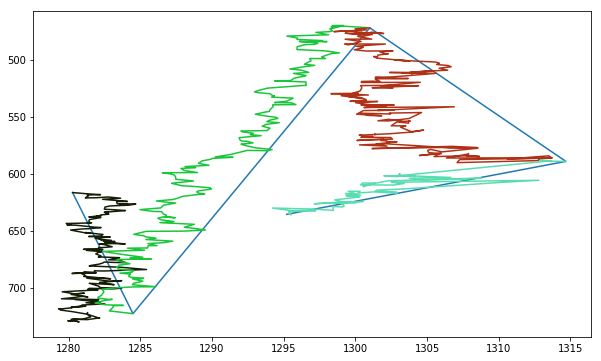

In [181]:
track = data_arr[4]
x = list(track['x'])
y = list(track['y'])
agg = [(x_val, y_val) for x_val, y_val in zip(x, y)]
agg = rdp(agg, 16.5)

fig = plt.figure()
plt.gca().invert_yaxis()

x_part, y_part = list(zip(*agg))
plt.plot(x_part, y_part)
fig.show()

changes = []
last_change = 0

track = track.reset_index(drop=True)

for x, y in agg[1:]:
    end = track.index[(track['x'] == x) & (track['y'] == y)][0]
    changes.append(track[last_change:end])
    last_change = end

for df in changes:
    plt.plot(list(df['x']), list(df['y']), c=np.random.rand(3,))

In [182]:
px_per_mm = ufloat(37, 2)*10
fps = 30

velocity_arr = []
for track in changes:
    # Convert px per mm to meter(s).
    track.x = track.x.apply(lambda x: x/(px_per_mm*1000))
    track.y = track.y.apply(lambda y: y/(px_per_mm*1000))
    
    velocities_y = []
    velocities_x = []
    velocities_net = []
    velocity_arr_net = []
    time_arr = []
    for i in range (1, len(track)):
        time = (track.frame.iloc[i] - track.frame.iloc[i-1])/fps
        pos_x = track.x.iloc[i] - track.x.iloc[i - 1]
        pos_y = track.y.iloc[i] - track.y.iloc[i - 1]

        velocities_y.append(pos_y/time)
        velocities_x.append(pos_x/time)
        
        # Neither are used atm.
        velocities_net.append(umath.sqrt(velocities_y[-1]*velocities_y[-1] + velocities_x[-1]*velocities_x[-1]))
        time_arr.append(track.frame.iloc[i] - track.frame.iloc[0])

    velocity_arr_net.append(np.mean(velocities_net[30:-30]))
    velocity_arr.append(np.mean(velocities_y[30:-30]))
    print(np.mean(velocities_y[30:]))
    # Now, get delta y over delta t, just to compare.
    print("delta",(track.y.iloc[-1] - track.y.iloc[30])/((track.frame.iloc[-1] - track.frame.iloc[30])/30))

(5.06+/-0.27)e-05
delta (5.03+/-0.27)e-05
(-9.9+/-0.5)e-05
delta (-9.7+/-0.5)e-05
(4.98+/-0.27)e-05
delta (5.01+/-0.27)e-05
(4.71+/-0.25)e-05
delta (4.71+/-0.25)e-05


The radius of the oil drop is given as
$$
a = \sqrt{\left(\frac{b}{2p}\right)^2 + \frac{9\eta v_f}{2g\rho}} - \frac{b}{2p}
$$
where:

$$
\begin{align}
b &=  8.20 x 10^{-3} Pa · m\\
g &= 9.81 m/s\\
p &= \text{barometric pressure in pascals}\\
\rho &= \text{density of oil in } kg/m^3\\
v_f &= \text{velocity of fall in } m/s\\
v_r &= \text{velocity of fall in } m/s
\end{align}
$$

The mass is given by
$$
m = \frac{4\pi a^3 \rho}{3}
$$

and $q$ is given by
$$
q = \frac{mg(v_f + v_r)}{Ev_f}
$$

In [180]:
for v_f, v_r in zip(velocity_arr[::2], velocity_arr[1::2]):
    v_f = abs(v_f) # m/s
    v_r = -v_r # m/s

    a, m, q = calc_results(v_f, v_r)
    print("Radius,", (a*1000), "mm | Mass,", m, "grams | Charge is ", q)

Radius, 0.000692+/-0.000022 mm | Mass, (1.20+/-0.11)e-15 grams | Charge is  (5.2+/-0.5)e-19
Radius, 0.000682+/-0.000021 mm | Mass, (1.15+/-0.11)e-15 grams | Charge is  (1.80+/-0.17)e-19


In [218]:
addr = '/home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df14/track*.csv'

t = lambda x: x*30

data_arr = []
for file in glob.glob(addr):
    print("Opening ", file)
    temp_df = pd.read_csv(file, sep='\t', index_col='frame')

    for element in temp_df['particle'].unique():
        data_arr.append(temp_df.loc[temp_df['particle'] == element])
        
run_0, run_1, run_2 = data_arr
run_0_up_0 = run_0.loc[:t(10)] # Note: already at terminal velocity
run_0_down_0 = run_0.loc[t(10):t(20)]
run_0_up_1 = run_0.loc[t(20):t(25)]
run_0_down_1 = run_0.loc[t(25):t(41)]
run_0_up_2 = run_0.loc[t(41):t(45)]
run_0_down_3 = run_0.loc[t(45):t(55)]
run_0_up_3 = run_0.loc[t(55):t(58)]
run_0_down_4 = run_0.loc[t(58):]

# Get a sample of what we have.
print(run_0_down_0)

Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df14/track0.csv
Opening  /home/ben/Dropbox/Documents/PHY240/Python/millikan/Trajectories/df14/track1.csv
       Unnamed: 0  Index    _1            x           y         mass  particle
frame                                                                         
300           188    300   809  1256.479188  592.934755  1536.270485     111.0
301           189    301   810  1256.386531  589.852926  1528.773881     111.0
302           190    302   811  1256.696912  588.308885  1596.139840     111.0
303           191    303   812  1256.046877  585.458589  1286.767605     111.0
304           192    304   813  1256.362181  583.358215  1255.552416     111.0
305           193    305   814  1257.283259  580.201404  1129.703543     111.0
306           194    306   815  1257.978636  577.486540  1220.544844     111.0
307           195    307   816  1258.588445  575.221260  1358.353144     111.0
308           196    308   817  